In [1]:
import glob
import io
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [30]:
BASE_DIR = '/home/kamal/codes/deepLearning/hackerEarth/'
TRAIN_DIR = '/home/kamal/codes/deepLearning/hackerEarth/train_dir/train_data'
TEST_DIR = '/home/kamal/codes/deepLearning/hackerEarth/test_dir/test_data'
IMG_SIZE = 64
data = np.load(BASE_DIR + 'trainbeg.npy')
test_data = np.load(BASE_DIR + 'testbeg.npy')
print("train_data shape: ", data.shape)
print("test_data shape:", test_data.shape)

train_data shape:  (13000, 64, 64, 3)
test_data shape: (6000, 64, 64, 3)


In [6]:
train_data = data[:9100]
print(train_data.shape)
validation_data = data[9100:]
print(validation_data.shape)

(9100, 64, 64, 3)
(3900, 64, 64, 3)


In [7]:
labels = np.load(BASE_DIR + 'trainLabels.npy')
print(labels.shape)
train_labels = labels[:9100]
print(train_labels.shape)
validation_labels = labels[9100:]
print(validation_labels.shape)

(13000, 1)
(9100, 1)
(3900, 1)


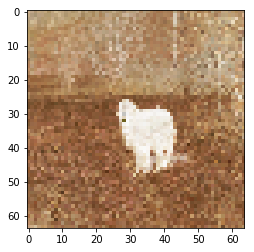

In [11]:
plt.imshow(np.array(train_data[10]))

In [22]:
#HYPERPARAMETERS
steps = 4800 # number of samples in trainiing set
epochs = 50 #number of epochs
step_size = 32 # 
total_batch = int(steps/step_size)
LR = 0.0001

In [12]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

In [13]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [14]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [15]:
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [16]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

In [17]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [18]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32,shape=[None,64,64,3])
y_true = tf.placeholder(tf.float32,shape=[None,4])

In [19]:
with tf.name_scope('Model'):
    convo_1 = convolutional_layer(x,shape=[4,4,3,32])
    convo_1_pooling = max_pool_2by2(convo_1)
    convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,16])
    convo_2_pooling = max_pool_2by2(convo_2)
    convo_3 = convolutional_layer(convo_2_pooling,shape=[4,4,16,8])
    convo_3_pooling = max_pool_2by2(convo_3)
    convo_4 = convolutional_layer(convo_3_pooling,shape=[4,4,8,4])
    convo_4_pooling = max_pool_2by2(convo_4)
    convo_2_flat = tf.reshape(convo_4_pooling,[-1,5*5*4])
    
    full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,80))
    hold_prob1 = tf.placeholder(tf.float32)
    full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob1)
    
    full_layer_two = tf.nn.relu(normal_full_layer(full_one_dropout,40))
    hold_prob2 = tf.placeholder(tf.float32)
    full_two_dropout = tf.nn.dropout(full_layer_two,keep_prob=hold_prob2)
                                     
    full_layer_three = tf.nn.relu(normal_full_layer(full_two_dropout,20))
    hold_prob3 = tf.placeholder(tf.float32)
    full_three_dropout = tf.nn.dropout(full_layer_three,keep_prob=hold_prob3)
    
    full_layer_four = tf.nn.relu(normal_full_layer(full_three_dropout,10))
    hold_prob4 = tf.placeholder(tf.float32)
    full_four_dropout = tf.nn.dropout(full_layer_four,keep_prob=hold_prob4)
    
    y_pred = normal_full_layer(full_four_dropout,4)

In [20]:
#Defining Loss Function
with tf.name_scope('Loss'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))

In [23]:
#Defining objectve
with tf.name_scope('ADAM'):
    train = tf.train.AdamOptimizer(learning_rate=LR).minimize(cross_entropy)

In [24]:
#Defining Accuracy
with tf.name_scope('Accuracy'):
    matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
    acc = tf.reduce_mean(tf.cast(matches,tf.float32))

In [25]:
#Starting variables
init = tf.global_variables_initializer()

In [26]:
tf.summary.scalar("loss", cross_entropy)
tf.summary.scalar("accuracy", acc)
merged_summary_op = tf.summary.merge_all()

In [27]:
#Defining empty lists to keep results
acc_list = []
cross_entropy_list = []
acc_train = []

In [28]:
#Creating a Saver object to save results
saver = tf.train.Saver()

In [32]:
#Changing settings for GPU running.
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'
#Training and saving the result
with tf.Session(config=config) as sess:
    sess.run(init)
    summary_writer = tf.summary.FileWriter(TRAIN_DIR, graph=tf.get_default_graph())
    for i in range(epochs):
        for j in range(0,steps,step_size):            
            _ , c , summary,d = sess.run([train_data, cross_entropy, merged_summary_op,acc], 
                                         feed_dict={x:train_data[j:j+step_size], y_true:train_labels[j:j+step_size], 
                                                    hold_prob1:0.5, hold_prob2:0.5, hold_prob3:0.5, hold_prob4:0.5})
            summary_writer.add_summary(summary, i * total_batch + j)
            acc_train.append(d)
            mean_of_cross_entropy = sess.run(cross_entropy, 
                                             feed_dict={x:validation_data, y_true:validation_labels, hold_prob1:1.0, 
                                                        hold_prob2:1.0, hold_prob3:1.0, hold_prob4:1.0})
            mean_of_acc = sess.run(acc, feed_dict={x:validation_data ,y_true:validation_labels, hold_prob1:1.0, 
                                                   hold_prob2:1.0, hold_prob3:1.0,hold_prob4:1.0})
            cross_entropy_list.append(mean_of_cross_entropy)
            acc_list.append(mean_of_acc)
        print(i,mean_of_cross_entropy,mean_of_acc)
    saver.save(sess, os.getcwd()+"\\CNN_MC.ckpt")
    print("test accuracy = ",np.mean([sess.run(acc,feed_dict={x:test_data[:400], y_true:test_labels[:400], 
                                                              hold_prob1:1.0,hold_prob2:1.0, hold_prob3:1.0, 
                                                              hold_prob4:1.0}),
                                      sess.run(acc,feed_dict={x:test_data[400:800], y_true:test_labels[400:800], 
                                                              hold_prob1:1.0, hold_prob2:1.0,hold_prob3:1.0, 
                                                              hold_prob4:1.0}), 
                                      sess.run(acc,feed_dict={x:test_data[800:], y_true:test_labels[800:] , 
                                                              hold_prob1:1.0, hold_prob2:1.0, hold_prob3:1.0, 
                                                              hold_prob4:1.0})]))   
    print("cross_entropy loss = ",np.mean([sess.run(cross_entropy,feed_dict={x:test_data[:400], y_true:test_labels[:400],
                                                                             hold_prob1:1.0, hold_prob2:1.0, 
                                                                             hold_prob3:1.0, hold_prob4:1.0}),
                                           sess.run(cross_entropy,feed_dict={x:test_data[400:800], 
                                                                             y_true:test_labels[400:800], 
                                                                             hold_prob1:1.0, hold_prob2:1.0, 
                                                                             hold_prob3:1.0,hold_prob4:1.0}), 
                                           sess.run(cross_entropy,feed_dict={x:test_data[800:],y_true:test_labels[800:],
                                                                             hold_prob1:1.0, hold_prob2:1.0,
                                                                             hold_prob3:1.0, hold_prob4:1.0})]))

ValueError: Cannot feed value of shape (32, 1) for Tensor 'Placeholder_1:0', which has shape '(?, 4)'